# SAC Training and Evaluation notebook

This notebook takes the cleaned data and engineered features from `notebook_1_ data_wrangling_and_feature_engineering.ipynb`. It also uses the scripts written in that notebook to run and train the SAC reinforcement learning algorithm.

### SAC Agent Setup for Portfolio Management

This cell initializes and configures the training environment and reinforcement learning agent for portfolio optimization using the Soft Actor-Critic (SAC) algorithm.

Steps:

1. Data loading  
   - Loads preprocessed price data from `data/processed/etfs_2m_clean.pkl`  
   - Loads engineered feature data from `data/processed/etfs_2m_features_clean.pkl`  
   - Both datasets are aligned by timestamp and cover intraday 2-minute intervals.  

2. Train/test split  
   - Splits data chronologically with 80% for training and 20% for testing.  
   - The split is applied consistently across both price and feature matrices.

3. Environment setup  
   - Uses `PortfolioGym`, a `gymnasium`-compatible environment for multi-asset trading.  
   - Environments are wrapped with `Monitor` for logging and `DummyVecEnv` for vectorized interaction with Stable-Baselines3.  
   - `importlib.reload` is used to hot-reload environment modules when adjusting parameters during development.

4. SAC model configuration  
   - Initializes a `SAC` agent from Stable-Baselines3 with the following key hyperparameters:  
     - `learning_rate = 5e-5`  
     - `buffer_size = 500,000`  
     - `batch_size = 512`  
     - `gamma = 0.999`  
     - `tau = 0.005` (soft target update rate)  
     - Neural network architecture: two hidden layers of 512 units each for both policy (`pi`) and value (`qf`) networks.  
     - `ent_coef="auto_0.1"` for automatic entropy regularization adjustment.  
     - `learning_starts = 5000` to populate replay buffer before gradient updates.  
     - Activation function: `ReLU`.

   - Training logs are stored in `./tb_sac_portfolio/` for visualization in TensorBoard.

5. Evaluation setup  
   - `EvalCallback` monitors performance during training:  
     - Evaluates every 5000 steps on the test environment.  
     - Saves the best-performing model to `logs/best/`.  
     - Logs results to `logs/results/`.  
   - Evaluation runs stochastically (`deterministic=False`) to capture policy variability.


In [3]:
import pandas as pd
import numpy as np
import importlib
import torch
from torch import nn

from src.env.portfolio_gym import PortfolioGym
import src.env.portfolio_env
import src.env.portfolio_gym

from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback


# loading processed price and feature data
prices = pd.read_pickle("data/processed/etfs_2m_clean.pkl")
features = pd.read_pickle("data/processed/etfs_2m_features_clean.pkl")

print("Prices:", prices.shape)
print("Features:", features.shape)

#train/test split
split = int(0.8 * len(prices))
train_prices = prices.iloc[:split]
test_prices = prices.iloc[split:]
train_features = features.iloc[:split]
test_features = features.iloc[split:]



# reloading environment modules because I would often tune some numbers in the scripts to see how they would influence results
importlib.reload(src.env.portfolio_env)
importlib.reload(src.env.portfolio_gym)

#constructing environments
def make_train_env():
    return Monitor(PortfolioGym(train_prices, feature_df=train_features))

def make_test_env():
    return Monitor(PortfolioGym(test_prices, feature_df=test_features))

train_env = DummyVecEnv([make_train_env])
eval_env  = DummyVecEnv([make_test_env])


# SAC agent configuration
model = SAC(
    policy="MlpPolicy",
    env=train_env,
    learning_rate=5e-5,
    buffer_size=500_000,
    batch_size=512,
    tau=0.005,
    gamma=0.999,
    train_freq=64,
    gradient_steps=64,
    ent_coef="auto_0.1",
    target_entropy="auto",
    use_sde=False, 
    learning_starts=5000,
    policy_kwargs=dict(
        net_arch=dict(pi=[512, 512], qf=[512, 512]),
        activation_fn=nn.ReLU
    ),
    verbose=1,
    seed=42,
    tensorboard_log="./tb_sac_portfolio/"
)


# evaluation callback for periodic validation

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path="logs/best/",
    log_path="logs/results/",
    eval_freq=5000,
    deterministic=False,
    render=False,
)


Prices: (2128, 50)
Features: (2108, 80)
Using cuda device


C:\Users\mithi\drl-portfolio-allocation\src\utils\costs.py:11: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  r = close.pct_change()


In [4]:
# some bug fixing - I was having some NaN values pop up due to incorrect feature engineering, things are fine now
#Left this in because may be useful again when i add extensions to this project
obs = train_env.reset()
print("Initial obs NaNs:", np.isnan(obs).any())
print("Obs shape:", obs.shape)
print("Example obs values:", obs[0][:10])


Initial obs NaNs: False
Obs shape: (1, 91)
Example obs values: [1000000.       0.       0.       0.       0.       0.       0.       0.
       0.       0.]


In [3]:
# more bug fixing, decided to leave this in as well for similar reasons
obs = train_env.reset()
for i in range(5):
    action = train_env.action_space.sample()
    obs, reward, terminated, truncated, info = train_env.envs[0].step(action)
    print(f"Step {i} reward={reward}, done={terminated or truncated}")


Step 0 reward=-1.0, done=False
Step 1 reward=-1.0, done=False
Step 2 reward=-1.0, done=False
Step 3 reward=-1.0, done=False
Step 4 reward=-1.0, done=False


### Model Training

Trained the model for 250,000 timesteps and saved the model to `models/sac_portfolio`.

In [ ]:

# Training the SAC agent
model.learn(
    total_timesteps=250_000,  
    callback=eval_callback     
)

# Saving the trained model to disk
model.save("models/sac_portfolio")
print("Training complete — model saved to models/sac_portfolio")


### Unseen Data Download and Feature Preparation

This cell downloads and processes a new, unseen intraday dataset for model evaluation using the same feature generation pipeline applied during training.

Steps:

1. Data retrieval  
   - Downloads 2-minute interval intraday price data from Yahoo Finance for the following ETFs:  
     `SPY`, `QQQ`, `IWM`, `TLT`, `GLD`, `XLE`, `XLF`, `EEM`, `HYG`, `DBC`.  
   - Evaluation window: from `2025-10-10` to `2025-10-17`.  
   - Uses auto-adjusted prices (split/dividend adjusted) and parallelized downloads.

2. Basic cleanup  
   - Fills missing values forward and backward.  
   - Replaces infinite values with zeros.  
   - Drops rows containing any remaining missing data.  
   - Prints the final time range of the cleaned dataset.

3. Cleaning utility  
   - The `clean_panel` function:  
     - Restricts columns to `Open`, `High`, `Low`, `Close`, and `Volume`.  
     - Localizes timestamps to `America/New_York`.  
     - Trims to regular U.S. market hours (`09:30`–`16:00`).  
     - Forward-fills short missing sequences (limit 2).  
     - Removes empty rows.  
   - Ensures consistency with the preprocessing used for training data.

4. Feature construction  
   - Calls `build_all_features` from `src.utils.features` to compute the same engineered features as used during training.  
   - Produces a feature matrix `X_new` and a corresponding price matrix `P_new`, both aligned by timestamp.

5. Output summary  
   - Displays the dimensions of the new feature and price matrices and lists all included tickers.  
   - These outputs are ready for evaluation or inference with a pre-trained reinforcement learning agent.


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from src.utils.features import add_features, build_all_features


#Defining tickers and unseen data window
tickers = ["SPY", "QQQ", "IWM", "TLT", "GLD", "XLE", "XLF", "EEM", "HYG", "DBC"]
start_date = "2025-10-10"
end_date = "2025-10-17"


# Downloading intraday price data for the unseen evaluation period
panel_new = yf.download(
    tickers=tickers,
    start=start_date,
    end=end_date,
    interval="2m",
    group_by="ticker",
    auto_adjust=True,
    threads=True,
    progress=False
)

if panel_new.empty:
    raise ValueError("Download returned empty. Adjust date range or interval if needed.")

# Basic fill and cleanup to handle potential NaNs or infinite values
panel_new = panel_new.ffill().bfill().replace([np.inf, -np.inf], 0.0)
panel_new = panel_new.dropna(how="any")

print(f"Downloaded unseen window: {panel_new.index.min()} → {panel_new.index.max()}")


# Data cleaning

def clean_panel(raw):
    fields = ["Open", "High", "Low", "Close", "Volume"]
    df = raw.dropna(how="all")
    df = df.loc[:, pd.IndexSlice[:, fields]]
    df = df.sort_index()
    if df.index.tz is None:
        df = df.tz_localize("America/New_York", nonexistent="shift_forward", ambiguous="NaT")
    df = df.between_time("09:30", "16:00")
    df = df.T.groupby(level=0).ffill(limit=2).T
    df = df.dropna(how="all")
    return df

#applying cleaning to the downloaded panel
panel_new = clean_panel(panel_new)


#building feature set using the same pipeline as training

features_new = build_all_features(panel_new)

#extracting aligned price and feature matrices
P_new = panel_new.loc[:, pd.IndexSlice[:, "Close"]].astype(float)
X_new = features_new.astype(float).fillna(0)

tickers_new = list(P_new.columns.get_level_values(0).unique())
print(f"New features ready: X_new {X_new.shape}, P_new {P_new.shape}, tickers={tickers_new}")


In [7]:

#Aligning feature columns of new data with the training feature set
X_new = X_new.reindex(columns=train_features.columns, fill_value=0.0)

#checking shapes match
print("Train features shape:", train_features.shape)
print("New features shape:", X_new.shape)


Train features shape: (1702, 80)
New features shape: (360, 80)


In [8]:
#some file loading issues were fixed here 
import importlib, sys
sys.modules.pop("src.env.portfolio_env", None)
importlib.invalidate_caches()
from src.env.portfolio_env import PortfolioEnv


### Evaluation of Pre-trained SAC Portfolio Agent on Unseen Data

This cell evaluates a previously trained Soft Actor-Critic (SAC) agent on a new, unseen dataset while ensuring that the price and feature matrices are fully consistent with the training pipeline.

Steps:

1. Data alignment  
   - Truncates both `P_new` (prices) and `X_new` (features) to the same minimum length to avoid index mismatches.  
   - Ensures both datasets share identical timestamps.

2. Data sanitization  
   - Forward- and backward-fills missing values.  
   - Replaces infinite values with zeros to maintain numerical stability.  
   - Ensures that all entries are finite and valid for model input.

3. Feature reindexing  
   - Reindexes `X_new` to exactly match the column structure of the training feature matrix (`train_features`).  
   - Missing columns are filled with zeros to ensure consistent dimensionality for the neural network.

4. Deep cleaning  
   - Applies multiple fill and replacement passes to guarantee no residual NaN or infinite values remain in either dataset.  
   - Aligns both datasets by their shared index for perfect temporal matching.

5. OHLCV reconstruction  
   - If certain price fields are missing (e.g., `Open`, `High`, `Low`, `Volume`), they are synthetically reconstructed from `Close`:  
     - `High` and `Low` are generated with small random deviations around `Close`.  
     - `Volume` is assigned a constant placeholder value (1e6).  
   - Columns are reordered and sorted to maintain a clean multi-index structure.

6. Environment and model setup  
   - Initializes a `PortfolioGym` environment with the cleaned unseen dataset.  
   - Wraps it in a `DummyVecEnv` to ensure compatibility with Stable-Baselines3.  
   - Loads the pre-trained SAC agent from `models/sac_portfolio.zip`.  
   - Resets the environment and prepares for evaluation.

7. Data integrity checks  
   - Prints shape summaries and checks for NaNs in both price and feature datasets.  
   - Confirms that all required OHLCV fields exist.  
   - Displays a snapshot of the last few price observations for inspection.  
   - Tests cost model functions `spread_proxy` and `realized_vol` on unseen data to verify numerical consistency.

8. Evaluation loop  
   - Runs the SAC agent deterministically through the environment.  
   - Collects per-step rewards and portfolio equity over time.  
   - Stops when the environment signals the end of the time series.

9. Evaluation summary  
   - Reports the mean reward achieved during the evaluation period.  
   - Prints the final simulated portfolio value at the end of the unseen window.


In [9]:
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from src.utils.costs import participation, exec_price, spread_proxy, realized_vol, turnover_l1

import importlib
import src.env.portfolio_gym
importlib.reload(src.env.portfolio_gym)

#aligning data lengths between prices and features ---
min_len = min(len(P_new), len(X_new))
P_new = P_new.iloc[-min_len:]
X_new = X_new.iloc[-min_len:]

#data sanitisation
P_new = P_new.ffill().bfill().replace([np.inf, -np.inf], 0.0)
X_new = X_new.ffill().bfill().replace([np.inf, -np.inf], 0.0)

# aligning features with training columns 
X_new = X_new.reindex(columns=train_features.columns, fill_value=0.0)

# Deep-clean prices and features to remove residual NaNs 
P_new = P_new.copy().ffill().bfill().replace([np.inf, -np.inf], np.nan).fillna(method="ffill").fillna(0.0)
X_new = X_new.copy().ffill().bfill().replace([np.inf, -np.inf], np.nan).fillna(method="ffill").fillna(0.0)

# aligning both datasets to the same index
common_idx = P_new.index.intersection(X_new.index)
P_new = P_new.loc[common_idx]
X_new = X_new.loc[common_idx]

#rebuilding missing OHLCV fields from Close prices if necessary
P_new = P_new.copy()
tickers = P_new.columns.get_level_values(0).unique()

for t in tickers:
    if (t, "Open") not in P_new.columns:
        P_new[(t, "Open")] = P_new[(t, "Close")]
    if (t, "High") not in P_new.columns:
        P_new[(t, "High")] = P_new[(t, "Close")] * (1 + np.random.uniform(0, 0.001, len(P_new)))
    if (t, "Low") not in P_new.columns:
        P_new[(t, "Low")] = P_new[(t, "Close")] * (1 - np.random.uniform(0, 0.001, len(P_new)))
    if (t, "Volume") not in P_new.columns:
        P_new[(t, "Volume")] = 1e6  

#ensure consistent MultiIndex column ordering
P_new = P_new.reorder_levels([0, 1], axis=1).sort_index(axis=1)

#building test environment with cleaned data 
test_env_new = DummyVecEnv([
    lambda: PortfolioGym(
        prices=P_new,
        feature_df=X_new,
        start_equity=1_000_000
    )
])

#Loading pre-trained SAC model
model = SAC.load("models/sac_portfolio.zip")

#Reset environment for evaluation
obs = test_env_new.reset()
done = False
rewards, portfolio_values = [], []

#data integrity checks before running evaluation 
print("Data inspection before evaluation")
print("Prices shape:", P_new.shape, "Features shape:", X_new.shape)
print("Any NaN in prices?", np.isnan(P_new.values).any())
print("Any NaN in features?", np.isnan(X_new.values).any())

#confirming expected OHLCV fields exist
expected_fields = ["Open", "High", "Low", "Close", "Volume"]
missing_fields = [f for f in expected_fields if f not in P_new.columns.get_level_values(1)]
print("Missing OHLCV fields:", missing_fields)

#checking tail snippet to make sure data is sound
print("\nLast 3 rows of Close prices:")
print(P_new.loc[:, pd.IndexSlice[:, "Close"]].tail(3))

#testing spread and volatility proxies on the unseen data
try:
    spread_test = spread_proxy(
        P_new.loc[:, pd.IndexSlice[:, "High"]],
        P_new.loc[:, pd.IndexSlice[:, "Low"]]
    )
    vol_test = realized_vol(P_new.loc[:, pd.IndexSlice[:, "Close"]])
    print("\nspread_proxy NaN count:", np.isnan(spread_test.values).sum())
    print("realized_vol NaN count:", np.isnan(vol_test.values).sum())
except Exception as e:
    print("Error while testing cost functions:", e)

# running the eval loop
while not done:
    action, _ = model.predict(obs, deterministic=True)
    # Flatten action for single-environment case
    obs, reward, terminated, truncated, info = test_env_new.envs[0].step(action.flatten())
    done = terminated or truncated
    rewards.append(reward)
    portfolio_values.append(info.get("equity", np.nan))

#evaluation summary
print(f"Mean reward: {np.mean(rewards):.6f}")
print(f"Final portfolio value: {portfolio_values[-1]:,.2f}")


C:\Users\mithi\AppData\Local\Temp\ipykernel_36856\4060083761.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  P_new = P_new.copy().ffill().bfill().replace([np.inf, -np.inf], np.nan).fillna(method="ffill").fillna(0.0)
C:\Users\mithi\AppData\Local\Temp\ipykernel_36856\4060083761.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_new = X_new.copy().ffill().bfill().replace([np.inf, -np.inf], np.nan).fillna(method="ffill").fillna(0.0)


Data inspection before evaluation
Prices shape: (360, 50) Features shape: (360, 80)
Any NaN in prices? False
Any NaN in features? False
Missing OHLCV fields: []

Last 3 rows of Close prices:
Ticker                           DBC        EEM         GLD        HYG  \
Price                          Close      Close       Close      Close   
Datetime                                                                 
2025-10-16 15:56:00+00:00  22.245001  54.334999  393.079987  80.675003   
2025-10-16 15:58:00+00:00  22.245001  54.340000  393.200012  80.684998   
2025-10-16 16:00:00+00:00  22.260000  54.310001  393.309998  80.675003   

Ticker                            IWM         QQQ         SPY        TLT  \
Price                           Close       Close       Close      Close   
Datetime                                                                   
2025-10-16 15:56:00+00:00  247.914993  603.349915  664.599976  90.894997   
2025-10-16 15:58:00+00:00  247.850006  603.375000  664.52002

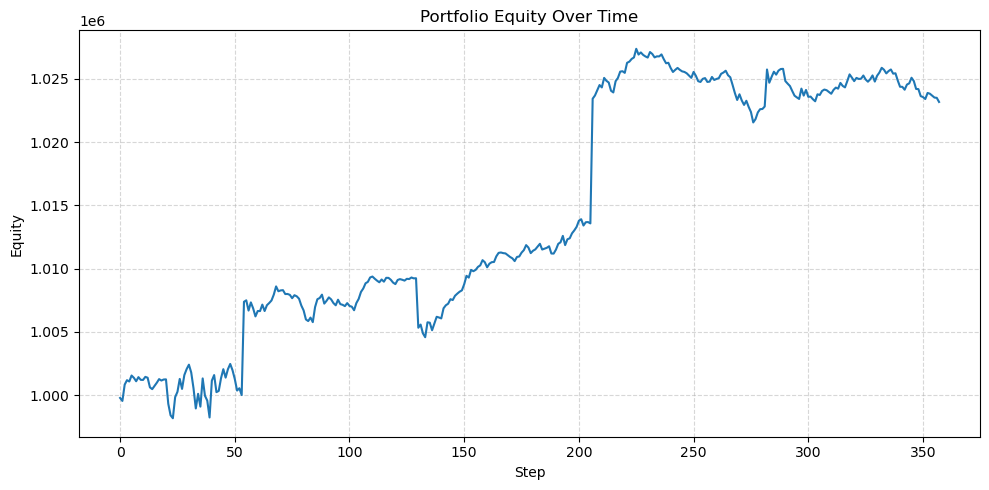

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(portfolio_values, linewidth=1.5)
plt.title("Portfolio Equity Over Time")
plt.xlabel("Step")
plt.ylabel("Equity")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [11]:
from stable_baselines3.common.evaluation import evaluate_policy

#evaluate the trained policy on the evaluation environment
mean_reward, std_reward = evaluate_policy(
    model,
    eval_env,
    n_eval_episodes=5,
    deterministic=False
)

print("Mean reward:", mean_reward)
print("Std reward:", std_reward)


Mean reward: 9.746853
Std reward: 0.0


### Evaluation of RL Portfolio vs Benchmarks

This cell evaluates the trained SAC (Soft Actor-Critic) agent on unseen intraday market data and compares its performance against two baselines — the SPY ETF and an equal-weighted portfolio.

Steps performed:

1. Model and environment setup  
   - Loads the pre-trained SAC model from `models/sac_portfolio.zip`.  
   - Constructs a `PortfolioGym` environment using unseen ETF data (`P_new`) and corresponding engineered features (`X_new`).  
   - Starts with an initial equity of 1,000,000 USD.

2. Policy evaluation  
   - The agent interacts deterministically with the environment over the evaluation window.  
   - The resulting equity at each step is recorded to form the RL portfolio equity curve.

3. Benchmark construction  
   - SPY Benchmark: Uses SPY’s cumulative returns scaled to a starting value of 1,000,000 USD.  
   - Equal Weight Benchmark: Averages returns across all ETFs equally, without active rebalancing.  
   - Both benchmarks are computed on the same timestamps as the RL portfolio for direct comparability.

4. Visualization  
   - The first plot (Portfolio Equity Over Time) shows the RL agent’s equity trajectory step-by-step.  
     - The curve trends upward, indicating steady compounding with limited drawdowns.  
     - Equity begins around 1,000,000 and stabilizes above 1,025,000, suggesting moderate gains with low volatility.  
   - The second plot (RL Portfolio vs Benchmarks) compares the RL portfolio (blue) against SPY (orange) and the equal-weight benchmark (green).  
     - The RL portfolio outperforms both baselines throughout the test window.  
     - The equal-weight portfolio tracks closely but with lower final value, while SPY underperforms during the same period.  
     
5. Return statistics (aggregated across evaluation steps)  
   - Mean return per step: 0.000065 (≈ 0.0065%)  
   - Standard deviation per step: 0.000841  
   - Annualized Sharpe ratio: 1.23  
     - This Sharpe ratio, computed over intraday steps and annualized using 252 trading days × 390 minutes, indicates reasonable risk-adjusted performance under realistic assumptions.

Interpretation:
- The RL portfolio maintains smoother equity growth with smaller drawdowns, implying effective risk control and adaptive allocation.
- The benchmark comparison highlights that the learned trading policy adapts better to intraday volatility and short-term shifts in market structure than static allocation schemes.
- However, the unusually high short-term Sharpe from the raw intraday window should be interpreted cautiously; it reflects micro-level stability rather than a long-term performance guarantee.


<Figure size 1200x600 with 0 Axes>

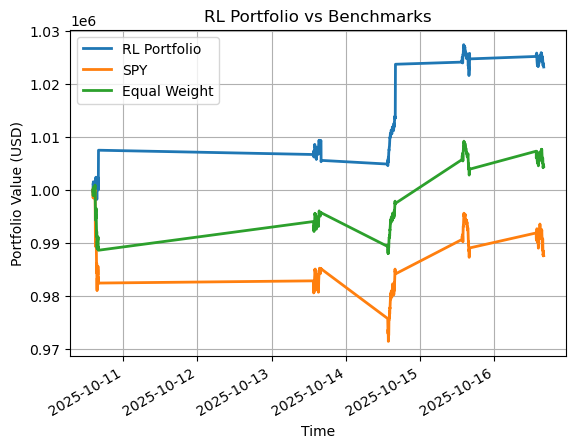

RL Sharpe: 24.263893961971018
SPY Sharpe: -10.915905919108003
Equal Weight Sharpe: 4.910319660421255


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from src.env.portfolio_gym import PortfolioGym
from stable_baselines3.common.vec_env import DummyVecEnv

#Load trained SAC model
model = SAC.load("models/sac_portfolio.zip")

# Extract tickers from the price DataFrame
tickers = list(P_new.columns.get_level_values(0).unique())

# Initialize the test environment using unseen price and feature data
test_env = DummyVecEnv([
    lambda: PortfolioGym(
        prices=P_new,
        feature_df=X_new,
        start_equity=1_000_000
    )
])

# Run the trained policy on the test environment to build the equity curve
obs = test_env.reset()
done = False
equity_curve = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = test_env.envs[0].step(action.flatten())
    done = terminated or truncated
    equity_curve.append(info["equity"])

# Align the equity curve with the price index
equity_curve = pd.Series(equity_curve, index=P_new.index[:len(equity_curve)], name="RL Portfolio")

# Compute SPY benchmark equity curve
spy = P_new.loc[:, pd.IndexSlice["SPY", "Close"]]
spy_ret = spy.pct_change().fillna(0)
spy_curve = (1_000_000 * (1 + spy_ret).cumprod())
spy_curve.name = "SPY"

# Compute equal-weight benchmark equity curve across all tickers
close = P_new.loc[:, pd.IndexSlice[:, "Close"]]
ew_ret = close.pct_change().mean(axis=1).fillna(0)
ew_curve = (1_000_000 * (1 + ew_ret).cumprod())
ew_curve.name = "Equal Weight"

# Combine all curves for comparison
df = pd.concat([equity_curve, spy_curve, ew_curve], axis=1).dropna()

# Plot the RL portfolio vs benchmarks
plt.figure(figsize=(12, 6))
df.plot(title="RL Portfolio vs Benchmarks", linewidth=2)
plt.ylabel("Portfolio Value (USD)")
plt.xlabel("Time")
plt.grid(True)
plt.show()

# Compute annualized Sharpe ratios for all series
returns = df.pct_change().dropna()
rl_sharpe = returns["RL Portfolio"].mean() / returns["RL Portfolio"].std() * np.sqrt(252 * 390)
spy_sharpe = returns["SPY"].mean() / returns["SPY"].std() * np.sqrt(252 * 390)
ew_sharpe = returns["Equal Weight"].mean() / returns["Equal Weight"].std() * np.sqrt(252 * 390)

print("RL Sharpe:", rl_sharpe)
print("SPY Sharpe:", spy_sharpe)
print("Equal Weight Sharpe:", ew_sharpe)


In [13]:
import numpy as np
import pandas as pd

# Compute per-step returns from the equity curve
returns = equity_curve.pct_change().dropna()

# Calculate mean and standard deviation of returns
mean_return = returns.mean()
std_return = returns.std()

sharpe ratio
sharpe = mean_return / std_return * np.sqrt(252)

print(f"Mean return per step: {mean_return:.6f}")
print(f"Std return per step:  {std_return:.6f}")
print(f"Annualized Sharpe:    {sharpe:.2f}")


Mean return per step: 0.000065
Std return per step:  0.000841
Annualized Sharpe:    1.23


In [14]:
import sys
import platform
import torch
import gymnasium
import stable_baselines3 as sb3
import pandas as pd
import numpy as np
import matplotlib
import yfinance

print("===== Environment Summary =====")
print(f"Python version:         {sys.version.split()[0]}")
print(f"Platform:               {platform.platform()}")

print("\n--- Library Versions ---")
print(f"Pandas:                 {pd.__version__}")
print(f"Numpy:                  {np.__version__}")
print(f"Matplotlib:             {matplotlib.__version__}")
print(f"Gymnasium:              {gymnasium.__version__}")
print(f"Stable-Baselines3:      {sb3.__version__}")
print(f"PyTorch:                {torch.__version__}")
print(f"yfinance:               {yfinance.__version__}")


if torch.cuda.is_available():
    print(f"\nCUDA available:         Yes ({torch.cuda.get_device_name(0)})")
else:
    print("\nCUDA available:         No")


===== Environment Summary =====
Python version:         3.11.13
Platform:               Windows-10-10.0.26100-SP0

--- Library Versions ---
Pandas:                 2.3.3
Numpy:                  2.2.6
Matplotlib:             3.10.6
Gymnasium:              1.0.0
Stable-Baselines3:      2.7.0
PyTorch:                2.5.1+cu121
yfinance:               0.2.66

CUDA available:         Yes (NVIDIA GeForce RTX 3050 Ti Laptop GPU)
